# 2. Mutual Information

## 선요약
1. `Mutual Information`은 새로운 데이터셋을 마주했을 때 가장 먼저 시도할 수 있는 방법이다. 
    - `Corrleation`과 비교했을 때, 선형성 이외의 다양한 관계에도 적용할 수 있다는 게 제일 큰 장점이다.
2. `MI`는 한 변수에 대한 정보가 다른 변수의 불확실성을 얼마나 줄일 수 있는지를 나타내는 척도이다.
    - 최솟값은 0(독립), 최댓값은 없으며 `log-scale`이므로 2 이상의 값은 흔하지 않다.
3. 파이썬에서는 `sklearn.feature_selection`에서 
    - 회귀 : `mutual_info_regression`
    - 분류 : `mutual_info_classif` 
    로 제공된다.
4. 변수 간 상호작용을 볼 수 있는 지표가 아니다!
------------------------------

새로운 데이터셋을 볼 때, 안내도 없이 수백, 수천개의 feature를 맞닥뜨리게 됨 : 어디서부터 시작해야 할까?  
**1번째로 가장 좋은 단계**는, `Feature Utility Metric`이다 : 타겟과 피쳐 사이의 관계를 측정하는 함수임
- 이는 `Mutual Information`이라고도 한다 : `Correlation`과 매우 유사하나, 선형적인 관계만을 볼 수 있는 `Correlation`에 비해 `Mutual Information`은 어떤 종류의 관계라도 볼 수 있다.

**처음에 뭘 할지 모를 때 가장 일반적으로 쓸 수 있다**. 이것의 장점으로는,
- 사용과 해석이 쉬움
- 연산에서도 효율적
- 이론적으로 잘 정립됨
- 오버피팅에 강함
- 어떤 종류의 관계라도 측정할 수 있음


## Mutual Information이 측정하는 것

`Mutual Information`은 **불확실성**을 측정한다. 두 양(Quantities) 사이의 상호 정보는 한 양에 대 한 지식이 다른 양에 대한 불확실성을 줄이는 정도의 척도이다. 
- 한 피쳐의 값을 알 때, 타겟에 대해 얼마나 더 많은 확신이 생기는가?

![이미지](Images/1.png)

- X축의 각 범주는 y값의 범위를 결정하는 요소로 보인다.
- 이 그래프에서 `ExterQual`이 `SalePrice`에 대해 갖는 `MI`값은, 4개의 `ExterQual` 값에 대한 `SalePrice`의 불확실성의 평균 감소`Average Reduction`이다. 
- 불확실성을 정보 이론에서는 "엔트로피"라고 한다. 엔트로피의 정의는, "해당 변수의 발생을 설명하기 위해 필요한 예/아니오 질문의 갯수"이다.
    - 변수에 대한 불확실성과, 질문의 수는 비례한다.
    - `MI`는 피쳐에 대해 기대하는 답변의 수이다.

## MI Score 해석하기

- 최솟값은 0이다. 두 변수가 독립적임. 한 변수로 다른 변수를 아예 설명할 수 없다.
- 최댓값은 없으며, **실제로 2.0 이상의 값은 흔치 않다.** (로그 스케일임)

![이미지2](Images/2.png)
- 오른쪽 그림 : `MI`는 어떤 종류의 연관성도 캡쳐한다

`MI`를 적용할 때 기억해야 할 것들
- `MI`는 타겟을 예측하는 feature의 잠재력을 이해하는 데 도움이 됨
- 다른 기능과 상호작용할 때 매우 유용할 수 있지만 단독으로는 유용하지 않다. `MI`는 피쳐 간의 상호작용을 탐지할 수는 없다. 일변량 측정법(`Univariate Metric`임.)
- 실제 유용도는 어떤 모델을 함께 쓰느냐에 의존한다. 타겟 간의 관계를 모델이 학습할 수 있을 때 유용하다.
    - 높은 `MI` 스코어를 가졌다고 해서 모델이 이를 바로 이용할 수 있다는 의미는 아니다. 연결을 표시하려면 feature를 변환할 필요가 있을 수 있다.

## 예제 : 1985 Automobiles

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('seaborn-whitegrid')

df = pd.read_csv('Automobile_data.csv')
df = df.drop('normalized-losses', axis = 1)
df = df.drop(df[df.values == '?'].index)
df[['horsepower', 'price']] = df[['horsepower', 'price']].astype('int')
df.head(2)

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500


- `MI`를 위한 사이킷런 알고리즘은 이산형 변수와 연속형 변수를 다르게 처리한다. 
- 경험에 근거한 규칙상(`a rule of thumb`), 
    - `float`는 연속형 변수 
    - `Categoricals`(`Object` or `Categorical`)은 `Label Encoding`을 통해 이산형 변수로 처리한다.


In [94]:
X = df.copy()
y = X.pop('price')

# Label Encoding은 이런 방법도 있다
for colname in X.select_dtypes('object'):
    X[colname], _ = X[colname].factorize()

# 모든 이산형 변수가 Int dtype을 가짐 
discrete_features = X.dtypes == int

- 사이킷런은 `MI`를 위한 수식을 `feature_selection` 모듈에 제공한다.
    - 실숫값을 위한 `mutual_info_regression`
    - 범주값을 위한 `mutual_info_classif`
- 이 예제에서 타겟값은 `price`로 실숫값이다.

In [95]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

horsepower      1.256615
highway-mpg     0.884214
length          0.615682
stroke          0.454908
drive-wheels    0.332922
symboling       0.234346
engine-type     0.158591
fuel-type       0.047298
Name: MI Scores, dtype: float64

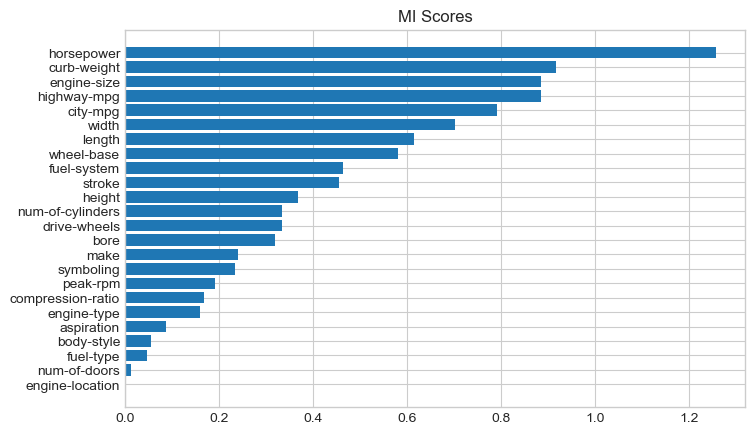

In [96]:
# 위를 barplot으로 나타냄
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('MI Scores')
    
plt.figure(dpi = 100, figsize = (8, 5))
plot_mi_scores(mi_scores)

- 시각화는 순위를 매긴 다음 진행하면 좋음

- `curb_weight`는 `price`와 강력한 관계를 나타낸다.

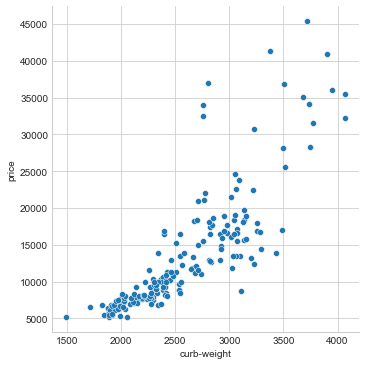

In [97]:
sns.relplot(x = 'curb-weight', 
            y = 'price', 
            data = df,
            kind = 'scatter' # 디폴트
           )

- 한편 `fuel_type`은 MI 스코어가 낮다. 
- 근데 `horsepower`에 따른 `price` 분포가 다름
    - 즉, `fuel_type`은 상호작용에 영향을 미친다 + 그 사실이 주요하다(might not be unimportant after all)
- 어떤 **피쳐를 `MI` 스코어로 중요하지 않다고 결정하기 전에, 가능한 상호작용들을 탐색하는 게 좋다** : 여기서 **도메인에 대한 지식은 많은 도움이 될 수 있다.**

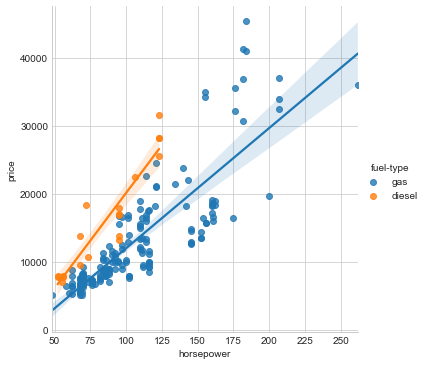

In [99]:
sns.lmplot(x="horsepower", y="price", hue="fuel-type", data=df)